In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

import theano.tensor as T
import theano
from itertools import izip
import random
from random import shuffle


## 讀取 Miku

In [3]:
img_count = 0
def showimg(img):
    muki_pr = np.zeros((500,500,3))
    l =img.tolist()
    count = 0
    for x in range(500):
        for y in range(500):
            muki_pr[y][x] = l[count]
            count += 1
    plt.imshow(muki_pr)
def saveimg(fname,img):
    muki_pr = np.zeros((500,500,3))
    l =img.tolist()
    count = 0
    for x in range(500):
        for y in range(500):
            muki_pr[y][x] = l[count]
            count += 1
    plt.imsave(fname,muki_pr)

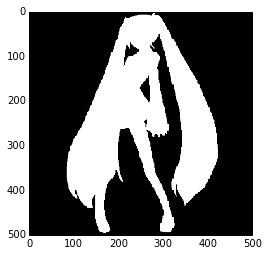

In [4]:
def read_muki():
    img_data = np.random.randn(250000,1)
    xy_data = []
    import random

    f = open('./muki.txt','rb')
    count = 0
    for line in f:
        y,x,c = line.split()
        xy_data.append([float(x),float(y)])
        x = (float(x) )*100. + 250
        y = (float(y) )*100. + 250
        c = float(c)

        img_data[count] = c
        
        count = count + 1
    return np.matrix(xy_data),img_data

xy_data,img_data = read_muki()    
showimg(img_data)


In [5]:
print xy_data[:10]
print img_data[:10]

[[-2.5  -2.5 ]
 [-2.49 -2.5 ]
 [-2.48 -2.5 ]
 [-2.47 -2.5 ]
 [-2.46 -2.5 ]
 [-2.45 -2.5 ]
 [-2.44 -2.5 ]
 [-2.43 -2.5 ]
 [-2.42 -2.5 ]
 [-2.41 -2.5 ]]
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


## Muki NN
<img width=500px src='./muki_nn.png' />

In [6]:
batch_size = 500
hidden_size = 128

In [7]:
x = T.matrix(name='x',dtype='float32') # size =2
y = T.matrix(name='x',dtype='float32') # size =1


w1 = theano.shared(np.random.randn(hidden_size,2))
b1 = theano.shared(np.random.randn(hidden_size))
w2 = theano.shared(np.random.randn(hidden_size,hidden_size))
b2 = theano.shared(np.random.randn(hidden_size))
w3 = theano.shared(np.random.randn(1,hidden_size))
b3 = theano.shared(np.random.randn(1))

## 第一層

In [8]:
z1 = T.dot(w1,x) + b1.dimshuffle(0,'x')
a1 = 1/(1+T.exp(-z1))

In [9]:
fa1 = theano.function(inputs=[x],outputs=[a1],allow_input_downcast=True)
l1_o= fa1(np.random.randn(2,batch_size))


In [10]:
l1_o= fa1(xy_data[:500].T)

## 第二層

In [11]:
z2 = T.dot(w2,a1) + b2.dimshuffle(0,'x')
a2 = 1/(1+T.exp(-z2))

In [12]:
fa2 = theano.function(inputs=[x],outputs=[a2],allow_input_downcast=True)

In [13]:
l2_o = fa2(np.random.randn(2,batch_size))

In [14]:
l2_o= fa2(xy_data[:500].T)
print l2_o[0].shape

(128, 500)


## 第三層

In [23]:
z3 = T.dot(w3,a2) + b3.dimshuffle(0,'x')
a3 = 1/(1+T.exp(-z3))

In [25]:
fa3 = theano.function(inputs=[x],outputs=[a3],allow_input_downcast=True)
l3_o = fa3(np.random.randn(2,batch_size))
print l3_o[0].shape

(1, 500)


## 定義 Cost Function & Update Function

In [26]:
y_hat = T.matrix('reference',dtype='float32')
cost = T.sum((a3-y_hat)**2)/batch_size

In [27]:
dw1,dw2,dw3,db1,db2,db3 = T.grad(cost,[w1,w2,w3,b1,b2,b3])

def Myupdates(ps,gs):
    from itertools import izip
 
    r = 0.5
    pu = [ (p,p-r*g) for p,g in izip(ps,gs)   ]
    return pu

In [29]:
train = theano.function(inputs=[x,y_hat],
                        outputs=[a3,cost],
                        updates=Myupdates([w1,w2,b1,b2,w3,b3],[dw1,dw2,db1,db2,dw3,db3]),
                        allow_input_downcast=True,)

## Training

In [32]:

def training(xy_data,img_data):
    for ii in range(1000):
        for i in range(500):

            start = i * 500 
            end  = start + 500
            img_predict,cost_predict = train(xy_data[start:end].T,img_data[start:end].T)

        if ii % 5 == 0:
            saveimg('./imgs/muki_'+ str(ii) +'.png', fa3(xy_data.T)[0].T)
        print cost_predict,

In [33]:
training(xy_data,img_data)

1.95025705114e-06 2.17305620986e-06 1.68649787039e-06 1.25956621256e-06 8.63419856337e-07 5.36193522996e-07 3.2976588041e-07 2.27709812058e-07 1.71146762211e-07 1.29372600136e-07 9.70224315787e-08 7.19332561151e-08 5.33969605359e-08 3.94842035864e-08 2.93452456106e-08 2.2706561381e-08 2.77263643607e-08 1.30487686622e-08 8.1193881343e-09 5.54503369581e-09 3.94160746659e-09 3.10275060885e-09 5.92385737653e-09 9.13232364591e-09 4.58839133446e-09 3.17988513431e-09 2.76569571208e-09 2.25529108265e-09 1.7455524496e-09 1.31412305514e-09 1.41116310656e-09 1.31992483818e-09 8.81222642023e-10 7.35196671871e-10 6.32639109534e-10 5.32096145923e-10 4.43074278112e-10 3.74625767394e-10 3.21590162479e-10 2.73204757981e-10 2.35410635127e-10 1.99438092939e-10 1.67679160499e-10 1.42884842354e-10 1.24156837642e-10 1.09978463444e-10 9.91420297121e-11 9.13505727662e-11 8.60160060876e-11 1.10311324466e-10 8.93050013613e-11 9.53464509221e-11 8.93464127494e-11 8.68752848509e-11 8.80314791815e-11 9.09302438081e

## Training - Random Suffule

In [ ]:
all_data = zip(xy_data,img_data)
shuffle(all_data)
temp_xy = []
temp_data = []
for row in all_data:
    temp_xy.append(row[0].tolist()[0])
    temp_data.append(row[1])


In [ ]:
s_data = np.matrix(temp_data)
s_xy = np.matrix(temp_xy)


## Testing

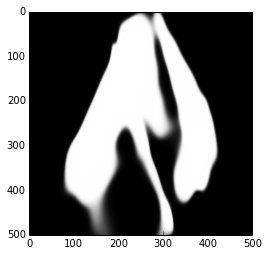

In [19]:
showimg(fa2(xy_data.T)[0].T)

## 結論:
* data 作 random suffule 的效果奇差，原因可以解釋為其實圖片的資料上下位置有相關系，如果 random 打散再作 mini batch ,反而喪失掉上下 pixle 之間相關的資料
* 在 hidden layer 設 128 個 neuron解釋力較強，至於原因需要再探咎
* 128 nerou <img width=100px src='./imgs/1_128_1/muki_810.png'>
* <a href='./imgs/output_2_128_1.mp4'>Training 過程</a>
* 256 nerou <img width=100px src='./imgs/2_256_1/muki_740.png/'>
* <a href='./imgs/output_2_256_1.mp4'>Training 過程</a>

